# SVM模型识别手写数字

**本次使用了MNIST数据集，依旧可以通过pytorch下载**

In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt
from time import time
from torchvision import datasets, transforms
from torch import nn, optim

In [2]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])

In [3]:
trainset = datasets.MNIST('PATH_TO_STORE_TRAINSET', download=True, train=True, transform=transform)
testset = datasets.MNIST('PATH_TO_STORE_TESTSET', download=True, train=False, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

**显示数据集的特点，包括张量长度等**

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


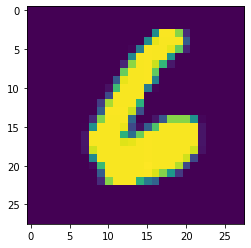

In [5]:
plt.imshow(images[0].numpy().squeeze())

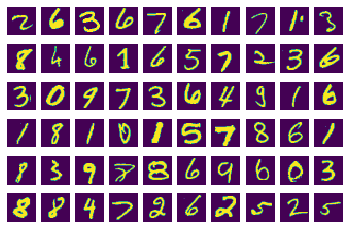

In [6]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze())

# 利用sklearn中的模块定义我们的模型

In [7]:
from sklearn import svm
import time

clf = svm.SVC()

In [8]:
pics = []
labels = []
for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, label = data
        pics.append(inputs)
        labels.append(label)

In [9]:
pictures = []
num_labels = []
for a in range(len(pics)):
    for pic in pics[a]: pictures.append(pic.numpy())
    for la in labels[a]: num_labels.append(la.numpy())

**pictures中是所有的手写数字图片**  
**num_labels是图片对应的数字**

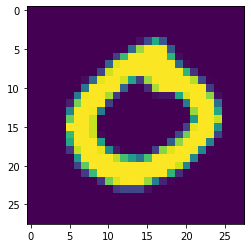

In [11]:
plt.imshow(pictures[1].squeeze())

In [12]:
print(num_labels[1])

0


**注意sklearn中的SVM模块只接受二维的输入。**  
**投入训练之前，我们要先把图片转换成一维的向量**

In [13]:
from sklearn import preprocessing

TwoDim_dataset = []
for pic in pictures:
     TwoDim_dataset.append(pic.reshape(1,-1)[0])  

**完工！ 此时TwoDim_dataset里面就是一维的图片向量**

# 开始训练！

In [14]:
print(time.strftime('%Y-%m-%d %H:%M:%S'))
clf.fit(TwoDim_dataset,num_labels)
print(time.strftime('%Y-%m-%d %H:%M:%S'))

2020-02-03 16:07:02
2020-02-03 16:15:55


# 开始对模型进行测试

**我们依旧使用pytorch的loader来逐个拉出测试图片。**


In [15]:
test_pics = []
test_labels = []
for i, data in enumerate(testloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, label = data
        test_pics.append(inputs)
        test_labels.append(label)
test_pictures = []
test_num_labels = []
for a in range(len(test_pics)):
    for pic in test_pics[a]: test_pictures.append(pic.numpy())
    for la in test_labels[a]: test_num_labels.append(la.numpy())

**测试集内的手写数字图片**

6


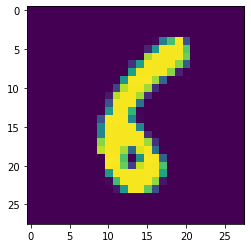

In [16]:
plt.imshow(test_pictures[1].squeeze())
print(test_num_labels[1])

**模型预测出来的结果**

In [17]:
two_DIM_test_pic1 = test_pictures[1].reshape(1,-1)
predict = clf.predict(two_DIM_test_pic1)
predict[0]

6

**测试准确度**

In [18]:
cnt = 0
correct = 0
for c in range(len(test_pictures)):
    pic_vector = test_pictures[c].reshape(1,-1)
    predicted = clf.predict(pic_vector)[0]
    label = test_num_labels[c]
    cnt += 1
    if predicted == label : correct += 1

print('模型准确度为： %d %%' % (
    100 * correct / cnt))

模型准确度为： 97 %


**如果没有出错的话，准确率大概有97%**

**打开摄像头，试试识别镜头里面的手写数字**
**参考：http://www.bnee.net/article/2359858.html**

In [18]:
import cv2

def findRoi(frame, thresValue):
    rois = []
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    gray2 = cv2.dilate(gray,None,iterations=2)    #两次膨胀
    gray2 = cv2.erode(gray2,None,iterations=2)    #两次腐蚀
    edges = cv2.absdiff(gray,gray2)    #做差，建立sobel算子进行边缘检测
    x = cv2.Sobel(edges,cv2.CV_16S,1,0)    
    y = cv2.Sobel(edges,cv2.CV_16S,0,1)
    absX = cv2.convertScaleAbs(x)
    absY = cv2.convertScaleAbs(y)
    dst = cv2.addWeighted(absX,0.5,absY,0.5,0)
    ret, ddst = cv2.threshold(dst,thresValue,255,cv2.THRESH_BINARY)    #转为二值图
    # im, contours, hierarchy = cv2.findContours(ddst,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    #寻找边界
    # 注意！ 以上代码适用于旧版opencv
    
    contours, hierarchy = cv2.findContours(ddst,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)    #寻找边界
    for c in contours:
        x, y, w, h = cv2.boundingRect(c)
        if w > 10 and h > 20:
            rois.append((x,y,w,h))
    digits = []
    for r in rois:
        x, y, w, h = r
        digit= findDigit(edges[y:y+h,x:x+w], 50)    #预测数值
        cv2.rectangle(frame, (x,y), (x+w,y+h), (153,153,0), 2)    #绘制矩形框
        cv2.putText(frame, str(digit), (x,y), cv2.FONT_HERSHEY_SIMPLEX, 1, (127,0,255), 2)    #绘制预测数字
    return edges


def findDigit(roi, thresValue):
    ret, th = cv2.threshold(roi, thresValue, 255, cv2.THRESH_BINARY)
    th = cv2.resize(th,(28,28))      # 图片变成28*28
    out = th.reshape(1,-1)
    result = clf.predict(out)     #预测结果
    return result

In [19]:
cap = cv2.VideoCapture(0)
width = 426*2
height = 480
videoFrame = cv2.VideoWriter('frame.avi',cv2.VideoWriter_fourcc('M','J','P','G'),25,(int(width),int(height)),True)
while True:
    ret, frame = cap.read()
    frame = frame[:,:426]
    edges = findRoi(frame, 50)
    newEdges = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    newFrame = np.hstack((frame,newEdges))
    cv2.imshow('frame', newFrame)
    videoFrame.write(newFrame)    #保存视频
    key = cv2.waitKey(1) & 0xff
    if key == ord('q'):
        break

KeyboardInterrupt: 

**吐槽：最后这个摄像头识别手写数字的真的把我吓到了。按理说之前在测试集里面我们跑出来的结果不差呀，结果不仅在镜头里面把大量的并非手写数字的部分识别成了手写数字，而且不论数字是什么，识别结果一定是5....郁闷啊！**   
**估计我们使用的笔和MNIST中的笔不一样。**   
**有能够在视频中实现更棒功能的，麻烦告诉我！**